<a href="https://colab.research.google.com/github/yashchks87/dogs_cats/blob/main/dogs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import re
import glob
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2
import random

In [ ]:
# Import data
trainData = glob.glob('./train/*.jpg')
testData = glob.glob('./test1/*.jpg')

In [ ]:
# Data visualization

In [ ]:
print(f'Total number of training data is {len(trainData)}.')
print(f'Total number of training data is {len(testData)}.')

Total number of training data is 25000.
Total number of training data is 12500.


In [ ]:
dogs, cats = 0,0
for x in trainData:
    temp = x.split('/')[-1]
    temp = temp.split('.')[0]
    if temp == 'cat':
        cats += 1
    else:
        dogs += 1

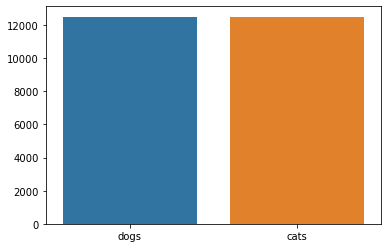

In [ ]:
# There is no class imbalancee, because both class data are equally distributed.
sns.barplot(x = ['dogs','cats'], y=[dogs,cats])
plt.show()

In [ ]:
# From above figure we can see both class are equally divided and there is no case of imbalanced classification.

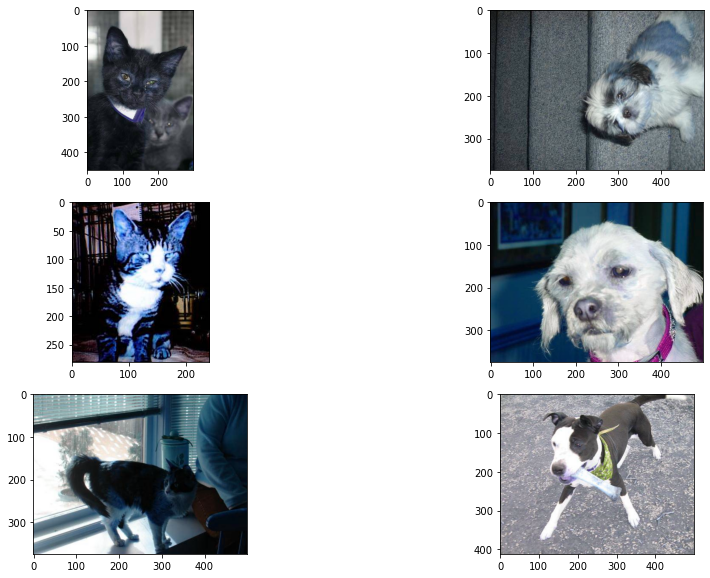

In [ ]:
# Let's plot some of the images as examples.
img1 = cv2.imread('./train/cat.3341.jpg')
img2 = cv2.imread('./train/dog.2789.jpg')
img3 = cv2.imread('./train/cat.10834.jpg')
img4 = cv2.imread('./train/dog.9715.jpg')
img5 = cv2.imread('./train/cat.4771.jpg')
img6 = cv2.imread('./train/dog.10262.jpg')
f, axis = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
axis[0,0].imshow(img1)
axis[0,1].imshow(img2)
axis[1,0].imshow(img3)
axis[1,1].imshow(img4)
axis[2,0].imshow(img5)
axis[2,1].imshow(img6)
plt.show()

In [ ]:
# As we compared earlier data is properly classified and in that case we do not need to make any big changes 
# like data augmentation and adding noise or something. We try to train with basic network if doesn't work we
# will add some noise to it.

In [ ]:
def decodeImageLabels(filePath):
#   Reading files from file path  
    bits = tf.io.read_file(filePath)
#   Converts image to numpy array and also divides it with 255 so all values fall between 0 to 1  
#   main reason for doing this is our model computation would be very lower.
    bits = tf.image.decode_jpeg(bits, channels=3) / 255
#   resizing images to 64x64
    image = tf.image.resize(bits, size=[64,64])
#   Decoding labels  
    temp = tf.strings.split(filePath, sep='/')[-1]
    temp = tf.strings.split(temp, sep='.')[0]
#   1 for dog, 0 for cat
    label = 1
    if temp =='cat':
        label = 0
    label = tf.reshape(label, [])
    return image, label

In [ ]:
# This will make sure we are utilizing all of our CPU cores as we know that data pre-processing runs on CPU
# model computation runs on GPU.
AUTOTUNE = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
# This will make sure to not follow order while data comes it will take data as data streams in
ignore_order.experimental_deterministic = False

In [ ]:
random.shuffle(trainData)
trainTestData, testTrainData = train_test_split(trainData, test_size=0.1)
trainValData, valTrainData = train_test_split(trainTestData, test_size=0.1)

In [ ]:
print(f'Training dataset size is {len(trainValData)}.\nValidation dataset size is {len(valTrainData)}.\nTest dataset size is {len(testTrainData)}.')

Training dataset size is 20250.
Validation dataset size is 2250.
Test dataset size is 2500.


In [ ]:
# Convert image paths to tensors
trainImages = tf.data.Dataset.from_tensor_slices(trainValData)
valImages = tf.data.Dataset.from_tensor_slices(valTrainData)

In [ ]:
trainImages = trainImages.with_options(ignore_order)
valImages = valImages.with_options(ignore_order)

In [ ]:
# AUTOTUNE will make sure we are using all the cores
trainImages = trainImages.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
# Repeting data so we can use multiple times on epoches.
trainImages = trainImages.repeat()
# Creating each batch with 512 images.
trainImages = trainImages.batch(512)
valImages = valImages.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
valImages = valImages.batch(512)

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose = 1, mode = 'min', restore_best_weights=True)

In [ ]:
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=2, activation='relu', padding='same', input_shape=[64,64,3]),
    keras.layers.Conv2D(filters=16, kernel_size=2, activation='relu', padding='same'),
    keras.layers.Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(filters=64, kernel_size=2, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(filters=128, kernel_size=2, activation='relu', padding='same'),
    keras.layers.MaxPool2D(3),
    # To stop overfitting at some place we place dropout points.
    keras.layers.Dropout(0.7),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision')])
  history = model.fit(trainImages, verbose=1, steps_per_epoch=100, epochs=70, validation_data=valImages, callbacks=[early])

Epoch 1/70
100/100 [==============================] - 74s 740ms/step - loss: 0.6919 - accuracy: 0.5199 - auc: 0.5259 - precision: 0.5224 - val_loss: 0.6878 - val_accuracy: 0.6182 - val_auc: 0.6608 - val_precision: 0.7308
Epoch 2/70
100/100 [==============================] - 74s 742ms/step - loss: 0.6583 - accuracy: 0.6072 - auc: 0.6409 - precision: 0.6477 - val_loss: 0.6006 - val_accuracy: 0.6964 - val_auc: 0.7817 - val_precision: 0.7945
Epoch 3/70
100/100 [==============================] - 73s 731ms/step - loss: 0.5970 - accuracy: 0.6861 - auc: 0.7450 - precision: 0.7422 - val_loss: 0.5589 - val_accuracy: 0.7116 - val_auc: 0.8126 - val_precision: 0.8380
Epoch 4/70
100/100 [==============================] - 74s 739ms/step - loss: 0.5633 - accuracy: 0.7148 - auc: 0.7857 - precision: 0.7571 - val_loss: 0.5124 - val_accuracy: 0.7533 - val_auc: 0.8447 - val_precision: 0.7477
Epoch 5/70
100/100 [==============================] - 74s 736ms/step - loss: 0.5347 - accuracy: 0.7400 - auc: 0.8132

Epoch 38/70
100/100 [==============================] - 75s 749ms/step - loss: 0.3026 - accuracy: 0.8787 - auc: 0.9465 - precision: 0.8842 - val_loss: 0.3143 - val_accuracy: 0.8676 - val_auc: 0.9502 - val_precision: 0.9302
Epoch 39/70
100/100 [==============================] - 75s 754ms/step - loss: 0.2979 - accuracy: 0.8812 - auc: 0.9481 - precision: 0.8886 - val_loss: 0.2835 - val_accuracy: 0.8742 - val_auc: 0.9528 - val_precision: 0.8918
Epoch 40/70
100/100 [==============================] - 74s 742ms/step - loss: 0.2899 - accuracy: 0.8853 - auc: 0.9506 - precision: 0.8892 - val_loss: 0.2781 - val_accuracy: 0.8818 - val_auc: 0.9537 - val_precision: 0.8763
Epoch 41/70
100/100 [==============================] - 74s 743ms/step - loss: 0.2884 - accuracy: 0.8832 - auc: 0.9512 - precision: 0.8841 - val_loss: 0.2903 - val_accuracy: 0.8698 - val_auc: 0.9501 - val_precision: 0.8690
Epoch 42/70
100/100 [==============================] - 74s 745ms/step - loss: 0.2867 - accuracy: 0.8839 - auc: 0

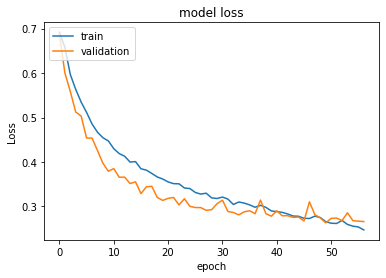

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

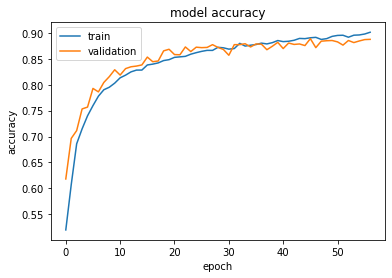

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
testImg = tf.data.Dataset.from_tensor_slices(testTrainData)
testImg = testImg.with_options(ignore_order)
testImg = testImg.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
testImg = testImg.batch(512)
testImg = testImg.prefetch(AUTOTUNE)

In [ ]:
model.evaluate(testImg)

5/5 [==============================] - 3s 545ms/step - loss: 0.2669 - accuracy: 0.8880 - auc: 0.9566 - precision: 0.8929


[0.26689502596855164,
 0.8880000114440918,
 0.9565552473068237,
 0.8928863406181335]